In [1]:
'''
documentation: https://pyportfolioopt.readthedocs.io/en/stable/

'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

%matplotlib inline


In [2]:
# Read in price data
df = pd.read_csv("Resources/multi_stock_prices.csv", parse_dates=True, index_col="Date")

In [3]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf()
mu

KOIN    0.172500
LQD     0.026092
SPY     0.116821
VNQ     0.058052
dtype: float64

In [4]:
sector_mapper = {
    "KOIN": "crypto",
    "LQD": "bonds",
    "SPY": "large_cap",
    "VNQ": "real_estate"
}

sector_lower = {
                "bonds": 0.3, # min 30% bonds
                "large_cap": 0.40 # min 40% equities
                } 

sector_upper = {
                "crypto": 0.5, # less than 5% crypto
                "real_estate": 0.10 # less than 10% real estate
                }

In [5]:
from pypfopt import objective_functions

ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
w = ef.min_volatility()
print(ef.clean_weights())

OrderedDict([('KOIN', 0.13228), ('LQD', 0.36772), ('SPY', 0.4), ('VNQ', 0.1)])


In [6]:
ef.portfolio_performance(verbose=True)

Expected annual return: 8.5%
Annual volatility: 15.7%
Sharpe Ratio: 0.41


(0.0849471939940649, 0.15660260240108345, 0.4147261475752817)

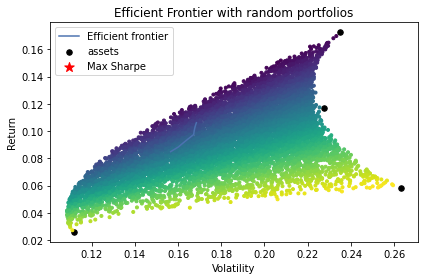

In [9]:
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Find the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()